In [1]:
import numpy as np
import pandas as pd

from pcntoolkit import BLRConf, NormConf, NormData
from pcntoolkit.normative_model.norm_factory import (
    create_normative_model,
    load_normative_model,
)

In [2]:
# First download the dataset from github
# fcon=pd.read_csv("https://raw.githubusercontent.com/pcn-toolkit/pcn-toolkit/master/resources/data/fcon1000.csv")
data = pd.read_csv("resources/data/fcon1000.csv")

In [3]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])

In [4]:
# Group the data by site and sex
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")

# Get the sites with only one sex present
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index

# remove the sites with less than 10 samples
data = data[~data["site"].isin(sites_with_one_sex.index)]


# find the sites that have less than 10 samples
site_counts = site_counts[site_counts["counts"] < 10]

# remove the sites with less than 10 samples
data = data[~data["site"].isin(site_counts["site"])]

We find the seven largest sites, which we will use for train and transfer. Two of those are randomly selected for transfering later.

In [5]:
site_counts = data.groupby(["site"]).size().reset_index(name="counts")
site_counts = site_counts.sort_values("counts", ascending=False)
site_counts = site_counts.head(7)
site_counts

np.random.seed(45)
# randomly select 2 sites from the top 7 sites for transfering
transfer_sites = site_counts.sample(2)["site"]
transfer_data = data[data["site"].isin(transfer_sites)]

# The remaining sites are used for training the model
fit_sites = site_counts[~site_counts.isin(transfer_sites)]["site"]
fit_sites.dropna(inplace=True)
fit_data = data[data["site"].isin(fit_sites)]

Next, we load the data into `NormData` objects. All functions in the PCNtoolkit expect the data to be provided as instances of the `NormData` class. The class manages all preprocessing, basis expansions, and dimensions. 

In [6]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]

# Create a normdata object from the downloaded data
normdata = NormData.from_dataframe(
    name="fit",  # name of the dataset
    dataframe=fit_data,  # pandas dataframe
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

# Create a transfer data object from the downloaded data
transfer_data = NormData.from_dataframe(
    name="transfer",
    dataframe=transfer_data,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

The NormData object has a number of useful attributes and functions, inherited from the `xarray.Dataset` class. A convenience function `select_batch_effects` is also available for quick filtering by site or sex(in this case). 

Splitting the data into train and test splits is also easy:

In [7]:
# Split data into training and test sets
# the splits are automatically stratified on the batch_effects
train, test = normdata.train_test_split(
    splits=[0.8, 0.2], split_names=["train", "test"]
)
transfer_train, transfer_test = transfer_data.train_test_split(
    splits=[0.8, 0.2], split_names=["transfer_train", "transfer_test"]
)

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [8]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    save_dir="resources/save_dir",
    log_dir="resources/log_dir",
    inscaler="none",
    outscaler="none",
    basis_function="bspline",
    order=3,
    nknots=5,
)

Configuration of normative model is valid.


## Configure the regression model


In [9]:
blr_conf = BLRConf(intercept=False)

Configuration of regression model is valid.


## Combine normative and hbr conf in normative model


In [10]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, blr_conf)
norm_hbr

## Fit the model

In [11]:
norm_hbr.fit(train)

Going to fit 2 models
Fitting model for rh_MeanThickness_thickness
Fitting model for WM-hypointensities


In [12]:
a = norm_hbr.regression_models["rh_MeanThickness_thickness"]
a.to_dict()

{'name': 'rh_MeanThickness_thickness',
 'reg_conf': {'n_iter': 300,
  'tol': 1e-05,
  'ard': False,
  'optimizer': 'l-bfgs-b',
  'l_bfgs_b_l': 0.1,
  'l_bfgs_b_epsilon': 0.1,
  'l_bfgs_b_norm': 'l2'},
 'is_fitted': True,
 'is_from_dict': False,
 'hyp': [4.969598747549685, -1.248982484491967],
 'nlZ': -490.40885019086073,
 'N': 476,
 'D': 8,
 'lambda_n_vec': [143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  143.96910782231868,
  1

In [13]:
norm_hbr.current_regression_model

## Save the model

In [14]:
# The results are saved in the save_dir specified in the norm_conf
norm_hbr.save()

## Inspecting the model 

## Load the norm_hbr model from disk

In [15]:
norm_hbr = load_normative_model("resources/save_dir")

Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.


In [16]:
norm_hbr.norm_conf.to_dict()

{'savemodel': True,
 'saveresults': False,
 'log_dir': 'resources/log_dir',
 'save_dir': 'resources/save_dir',
 'basis_function': 'bspline',
 'basis_column': 0,
 'order': 3,
 'nknots': 5,
 'inscaler': 'none',
 'outscaler': 'none',
 'perform_cv': False,
 'cv_folds': 0,
 'normative_model_name': 'NormBLR'}

## Predict on the test set


In [17]:
norm_hbr.predict(test)

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


ValueError: shapes (120,9) and (8,) not aligned: 9 (dim 1) != 8 (dim 0)

## Evaluation
Calling `predict` will extend the `NormData` object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [51]:
display(test.measures.to_dataframe())

measures
response_vars              statistics            
rh_MeanThickness_thickness Rho           0.318308
                           RMSE          0.062810
                           SMSE          0.703875
                           ExpV          0.296428
                           NLL                NaN
                           ShapiroW      0.977642
WM-hypointensities         Rho           0.000576
                           RMSE        786.718898
                           SMSE          0.612306
                           ExpV          0.388102
                           NLL                NaN
                           ShapiroW      0.688459

Datasets with a zscores DataArray will have the `.plot_qq()` function available:

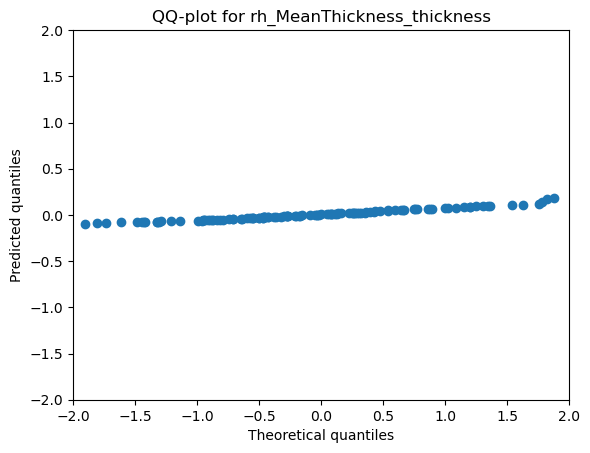

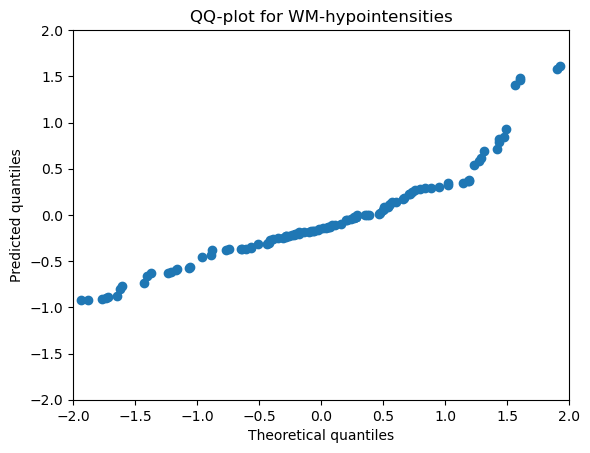

In [52]:
test.plot_qq(bound=2)  # Convenience function that plots the qq plot of the zscores

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`test` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.1587, 0.25, 0.5, 0.75, 0.8413, 0.95]. 

The CDF values of 0.1587 and 0.8413 respectively correspond to a standard deviation of -1 and 1.


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


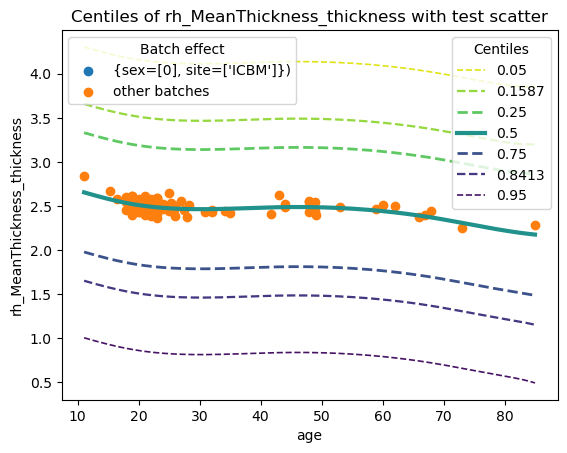

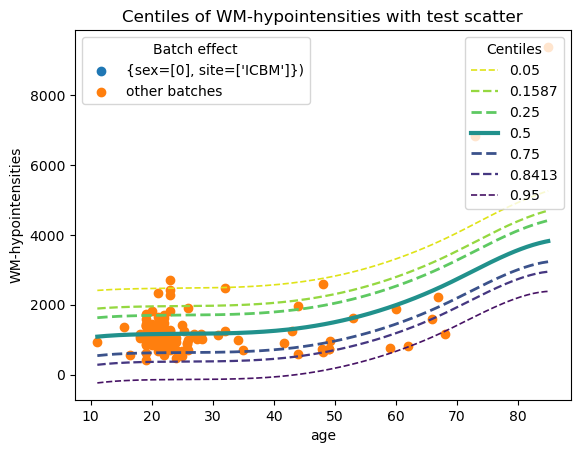

In [53]:
# test.centiles # the centiles
norm_hbr.plot_centiles(
    test, covariate="age", batch_effects={"sex": [0], "site": ["ICBM"]}, show_data=True
)